# Cross-Entropy Method

### 0. Background: Cross-Entropy Method and Evolution Strategies

In addition to [hill climbing](../hill-climbing/hill_climbing.ipynb), other black-box optimization techniques include:

1. **Cross-Entropy Method**:
   - Select the top-performing policies and average their parameters to guide the search.
2. **Evolution Strategies**:
   - Use a weighted sum of all candidate policies, where higher-performing policies have greater influence.

These methods leverage information from multiple policies, making them more robust and efficient than hill climbing. In this section, we will explore the implementation of these algorithms and compare their performance.

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [6]:
import math
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

import time
from PIL import Image
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

### 2. Instantiate the Environment and Agent

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Training on: {device}")

env = gym.make('MountainCarContinuous-v0')

np.random.seed(101)

print('observation space:\n', env.observation_space)
print('action space:\n', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

Training on: mps
observation space:
 Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space:
 Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]


In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]

        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        """
        Set the weights for the neural network layers using a flat array of weights.

        Args:
            weights (numpy.ndarray): Flat array containing weights for all layers.
        """
        def extract_weights(start, size):
            """Helper function to extract and reshape weights."""
            end = start + size
            return torch.from_numpy(weights[start:end]), end

        # Extract and reshape weights for fc1 layer
        fc1_weight_size = self.s_size * self.h_size
        fc1_bias_size = self.h_size

        fc1_W, next_idx = extract_weights(0, fc1_weight_size)
        fc1_b, next_idx = extract_weights(next_idx, fc1_bias_size)

        # Extract and reshape weights for fc2 layer
        fc2_weight_size = self.h_size * self.a_size
        fc2_bias_size = self.a_size

        fc2_W, next_idx = extract_weights(next_idx, fc2_weight_size)
        fc2_b, _ = extract_weights(next_idx, fc2_bias_size)

        # Set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        """
        Calculate the total number of weights and biases required for the network.

        Returns:
            int: Total number of weights and biases.
        """
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        """
        Evaluate the agent's performance using the given weights.

        Args:
            weights (numpy.ndarray): Flat array containing weights for all layers.
            gamma (float): Discount factor.
            max_t (int): Maximum number of timesteps per episode.

        Returns:
            float: Total discounted return for the episode.
        """
        self.set_weights(weights)
        episode_return = 0.0
        state, _ = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

### 3. Train the Agent with the Cross-Entropy Method


Episode 10	Average Score: -11.79
Episode 20	Average Score: -23.53
Episode 30	Average Score: 5.64
Episode 40	Average Score: 57.94

Environment solved in -54 iterations!	Average Score: 91.85


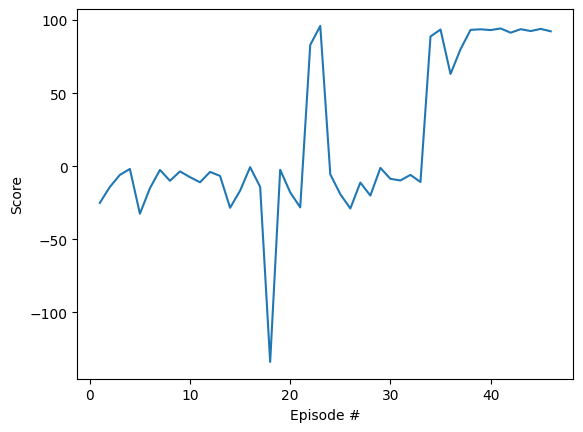

In [4]:
def cem(
    n_iterations=500,
    max_t=1000,
    gamma=1.0,
    window=10,
    population_size=50,
    elite_frac=0.2,
    sigma=0.5,
):
    """PyTorch implementation of the cross-entropy method.

    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        window (int): how often to print average score (over last 100 episodes)
        population_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite = int(population_size * elite_frac)

    scores_window = deque(maxlen=window)
    scores = []
    best_weight = sigma * np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations + 1):
        weights_population = [
            best_weight + (sigma * np.random.randn(agent.get_weights_dim()))
            for i in range(population_size)
        ]
        rewards = np.array(
            [agent.evaluate(weights, gamma, max_t) for weights in weights_population]
        )

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_population[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        
        scores_window.append(reward)
        scores.append(reward)

        torch.save(agent.state_dict(), "checkpoint.pth")

        if i_iteration % window == 0:
            print(
                "Episode {}\tAverage Score: {:.2f}".format(
                    i_iteration, np.mean(scores_window)
                )
            )

        if np.mean(scores_window) >= 90.0:
            print(
                "\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}".format(
                    i_iteration - 100, np.mean(scores_window)
                )
            )
            break
    return scores


scores = cem(
    n_iterations=500,
    max_t=1000,
    gamma=1.0,
    window=10,
    population_size=50,
    elite_frac=0.2,
    sigma=0.5,
)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

### 4. Watch a Smart Agent!


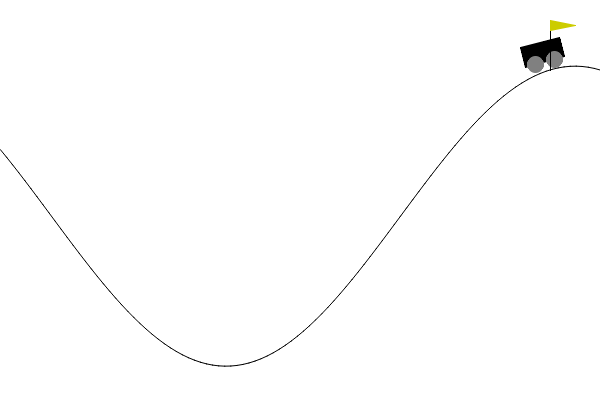

In [7]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")

state, _ = env.reset()
while True:
    display.clear_output(wait=True)
    
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    
    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.01)

    next_state, reward, done, _, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()